<font size="10">Discovering Conjugate Mappings: Conjugacy Between the Gissinger Poincare Map and the Logistic map</font>

<font size="4">This notebook employs an autoencoder neural network structure to discover a conjugacy between the Poincare map of the Rossler system and a cubic map. The 2-dimensional Poincare mapping (observed in collected data) is nearly 1-dimensional, as measured by the Lyapunov exponents and Kaplan-Yorke dimension. We employ an autoencoder neural network architecture to reduce the data to a 1-dimensional manifold and learn a cubic map representation of it.  </font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.5 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# Gissinger right-hand-side (scaled)
def Gissinger(x,t):
	# System parameters
	mu = 0.12 # bifurcation parameter
	nu = 0.1
	gamma = 0.85

	# Equilibria for scaling
	xstar = np.sqrt(nu + gamma*np.sqrt(nu/mu))
	ystar = np.sqrt(mu + gamma*np.sqrt(mu/nu))
	zstar = -np.sqrt(nu*mu) - gamma

	# Rescaled variables
	x1hat = x[0]*xstar
	x2hat = x[1]*ystar
	x3hat = x[2]*zstar

	dxdt = [(mu*x1hat - x2hat*(x3hat + gamma))/xstar, (-nu*x2hat + x1hat*(x3hat + gamma))/ystar, (-x3hat + x1hat*x2hat)/zstar]

	return dxdt

In [3]:
# Continuous-time simulation data

# Initializations
dt = .005
t_span = np.arange(0, 30000, dt)
x0 = [-1.5, 1.5, 1.3]

# Solution data
xsol = []
xsol = odeint(Gissinger, x0, t_span)

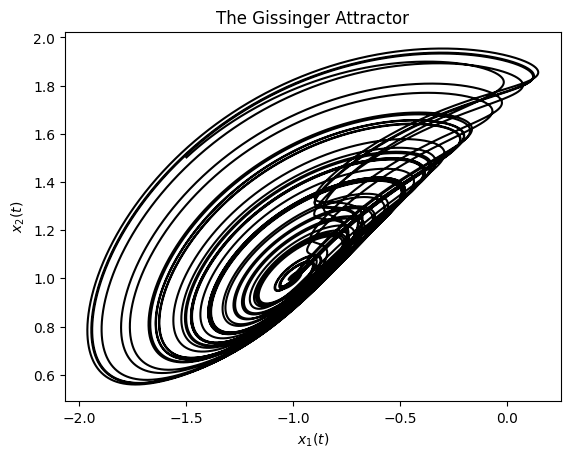

In [ ]:
# Plot Gissinger Solution (x_2 vs. x_1)

plt.plot(xsol[1:100000,0],xsol[1:100000,1],'k')
plt.title("The Gissinger Attractor")
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_2(t)$");

In [4]:
# Create section data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if (xsol[m,0] + xsol[m,1]) <= 0 and (xsol[m+1,0] + xsol[m+1,1]) >= 0: # section condition
        temp[count] = xsol[m+1,1:]
        count = count + 1
Psec.append(np.array(temp[1:count]))

xn, xnp1 = Psec[0][:-1], Psec[0][1:]

#Scale data into [0,1]
max_xn = xn.max()
min_xn = xn.min()

slope = 1/(max_xn - min_xn)
yint = -slope*min_xn

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

xnp1 = xnp1[:-forward_iters]
for j in range(forward_iters):
    xnforward.append(torch.tensor(xn[j:-forward_iters+j], dtype=torch.float32).to(device))

xnforward = torch.permute(torch.stack(xnforward), (1, 2, 0))

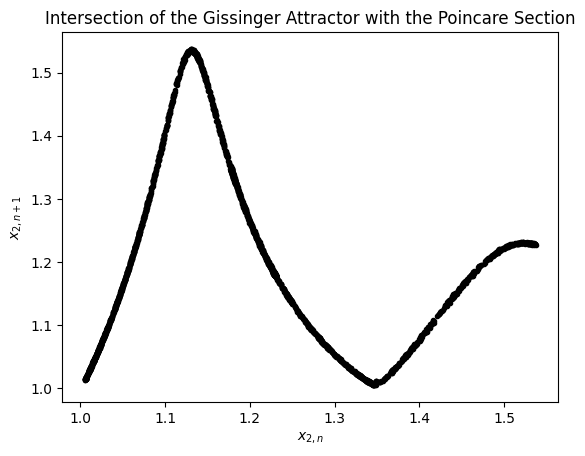

In [ ]:
# Plot Rossler Section Data

plt.plot(Psec[0][:-1,0],Psec[0][1:,0],'k.')
plt.title("Intersection of the Gissinger Attractor with the Poincare Section")
plt.xlabel("$x_{2,n}$")
plt.ylabel("$x_{2,n+1}$");

In [5]:
# Conjugacy neural network architecture

class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 2,
                 size_y = 1,
                 activation = nn.SELU(),
                 steps = 1,
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.steps = steps
        self.numblksIn = numblksIn
        self.numblksOut = numblksOut
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Trainable network parameter
        self.c1 = nn.Parameter(torch.tensor(8.534422, requires_grad=True))
        self.c2 = nn.Parameter(torch.tensor( -18.299885, requires_grad=True) )
        self.c3 = nn.Parameter(torch.tensor(9.817207, requires_grad=True) )

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function
        decoder_layers = [nn.Linear(self.size_y, self.width)]
        for _ in range(self.numblksOut-1):  # adding more layers
            decoder_layers.append(nn.Linear(self.width, self.width))
            decoder_layers.append(self.activation)

        decoder_layers.append(nn.Linear(self.width, size_x))
        decoder_layers.append(self.activation)
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0, std=0.1)
            nn.init.normal_(module.bias, mean=0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x[:, :, 0])
        encoded_p1 = self.c1*encoded + self.c2*torch.square(encoded) + self.c3*torch.square(encoded)*encoded
        decoded = self.decoder(encoded_p1)

        # Conjugacy loss
        x_recon = self.decoder(encoded)
        loss = torch.mean(torch.square(x[:, :, 0] - x_recon))

        # Build loss function
        yn = encoded
        for s in range(self.steps):
            ynp1 = self.encoder(x[:, :,s+1])

            # Iteration loss in y
            y_step = self.c1*yn + self.c2*torch.square(yn) + self.c3*torch.square(yn)*yn
            loss += torch.mean(torch.square(ynp1 - y_step))/self.steps

            # Iteration loss in x
            xnp1 = self.decoder(y_step)
            loss += torch.mean(torch.square(x[:, :,s+1] - xnp1))/self.steps

            yn = y_step

        # # L1L2 Regularization loss
        loss += sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        return decoded, loss

In [6]:
# Neural Network Parameters

width = 100 # width of each NN layer
size_x = 2 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = nn.SELU() # nonlinear activation function at each NN layer
steps = 1 # Number of steps for loss function
learning_rate = 0.00001
numblks_in = 3 # number of layers for the encoder NN
numblks_out = 3 # number of layers for the decoder NN

conjugacy = Conjugacy(width, size_x, size_y, activation, steps, numblks_in, numblks_out)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

xnforward = torch.tensor(xnforward, dtype=torch.float32, requires_grad=True).to(device)
train_dataloader = DataLoader(xnforward, batch_size=32)

<ipython-input-6-2e9d1ecfb629>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xnforward = torch.tensor(xnforward, dtype=torch.float32, requires_grad=True).to(device)


In [7]:
def train(model, optimizer, train_dataloader, epochs=10, patience=200):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        min_loss = float('inf')
        for xt in train_dataloader:
            optimizer.zero_grad()
            decoded, loss = model(xt)

            loss.backward()
            optimizer.step()

            min_loss = min(min_loss, loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {min_loss}")

        if min_loss < best_loss:
            best_loss = min_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train(conjugacy, optimizer, train_dataloader, epochs=100)

Epoch 1/100, Loss: 0.9692721366882324
Epoch 2/100, Loss: 0.5209791660308838
Epoch 3/100, Loss: 0.1957862228155136
Epoch 4/100, Loss: 0.13247641921043396
Epoch 5/100, Loss: 0.10054053366184235
Epoch 6/100, Loss: 0.08763745427131653
Epoch 7/100, Loss: 0.08156554400920868
Epoch 8/100, Loss: 0.07937251031398773
Epoch 9/100, Loss: 0.0785718560218811
Epoch 10/100, Loss: 0.07821357995271683
Epoch 11/100, Loss: 0.07796967029571533
Epoch 12/100, Loss: 0.07780890166759491
Epoch 13/100, Loss: 0.07770687341690063
Epoch 14/100, Loss: 0.07764115184545517
Epoch 15/100, Loss: 0.07759606093168259
Epoch 16/100, Loss: 0.07756723463535309
Epoch 17/100, Loss: 0.0775473490357399
Epoch 18/100, Loss: 0.07753238826990128
Epoch 19/100, Loss: 0.07751793414354324
Epoch 20/100, Loss: 0.07750296592712402
Epoch 21/100, Loss: 0.07748834788799286
Epoch 22/100, Loss: 0.0774725005030632
Epoch 23/100, Loss: 0.07745546847581863
Epoch 24/100, Loss: 0.07743781805038452
Epoch 25/100, Loss: 0.07741792500019073
Epoch 26/100, L

In [8]:
# Print Discovered Mapping

print('Discovered Conjugate Mapping:')
print('')
print('g(y) =',conjugacy.c1.detach().numpy(),'*y +',conjugacy.c2.detach().numpy(),'*y^2 +',conjugacy.c3.detach().numpy(),'*y^3')

# Network Summary
print('')
conjugacy

Discovered Conjugate Mapping:

g(y) = 8.531895 *y + -18.301485 *y^2 + 9.815709 *y^3



Conjugacy(
  (activation): SELU()
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): SELU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): SELU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): SELU()
    (6): Linear(in_features=100, out_features=1, bias=True)
    (7): SELU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): SELU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): SELU()
    (5): Linear(in_features=100, out_features=2, bias=True)
    (6): SELU()
  )
)

In [ ]:
# Loading and view the saved model
import tensorflow as tf

def loadModel(file_path, numblksIn=1, numblksOut=1):
    tf_model = tf.keras.models.load_model(file_path, compile=False)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(numblksIn=numblksIn, numblksOut=numblksOut).to(device)
    for i in range(numblksIn+1):
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    for i in range(numblksOut+1):
        pytorch_model.decoder[2*i].weight = nn.Parameter(conju_wt[2*(i+numblksIn+1)].T)
        pytorch_model.decoder[2*i].bias = nn.Parameter(conju_wt[2*(i+numblksIn+1)+1])

    # load variables
    variables = [
        'pytorch_model.c1 = nn.Parameter(torch.tensor(tf_model.c1.numpy()).to(device))',
        'pytorch_model.c2 = nn.Parameter(torch.tensor(tf_model.c2.numpy()).to(device))',
        'pytorch_model.c3 = nn.Parameter(torch.tensor(tf_model.c3.numpy()).to(device))',
    ]

    for line in variables:
        try:
            exec(line)
        except Exception as e:
            pass

    return pytorch_model

conjugacy = loadModel("../saved_conjugacy_networks/gissinger")

In [ ]:
print('Discovered Conjugate Mapping:')
print('')
print('g(y) =',conjugacy.c1.cpu().detach().numpy(),'*y +',conjugacy.c2.cpu().detach().numpy(),'*y^2 +',conjugacy.c3.cpu().detach().numpy(),'*y^3')

Discovered Conjugate Mapping:

g(y) = 8.534422 *y + -18.299885 *y^2 + 9.817207 *y^3
